# Machine Learning flow rule

Machine Learning (ML) algorithms provide a great flexibility to describe aribitrary mathematical functions. At the same time they offer the possibility to handle large data sets and multi-dimensional features as input. Hence, using ML algorithms as constitutive rules for plastic material behavior offers the possibility to explicitly take into account microstructural information of the material in the constitutive modeling. Furthermore, data resulting from experiment and micromechanical simulations can be hybridized to generate training data sets. The present example is using Support Vector Classification (SVC) as yield function. The SVC algorithm is trained by using deviatoric stresses as input data and the information whether a given stress state leads to purely elastic or rather to elastic-plastic deformation of the material as result data. In this way, a ML yield function is obtained, which can determine whether a given stress state lies inside or outside of the elastic regime of the material. Furthermore, the yield locus, i.e., the hyperplane in stress space on which plastic deformation occurs, can be reconstructed from the SVC, and the gradient on this yield locus can be conveniently calculated. Therefore, the standard formulations of continuum plasticity, as the return mapping algorithm, can be applied in Finite Element Analysis (FEA) in the usual way. Thus, it is demonstrated that the new ML yield function can replace conventional FEA yield functions. In a next step, microstructural information will be considered directly as feature. Machine learning algorithms have been adopted from the scikit-learn platform (https://scikit-learn.org/stable/).

This package demonstrates the training and application of ML flow rules in FEA in form of a simple example with data synthetically produced from standard flow rules, like isotropic J2 (von Mises) and Hill-type anisotropic plasticity. It uses the pyLabFEM module.

Author: Alexander Hartmaier, ICAMS, Ruhr-Universtität Bochum, Germany, March 2020

## Theoretical background
The yield function of a material is defined as 
\begin{equation} f = \sigma_{eq} - \sigma_y\,, \end{equation}
where plastic deformation sets in at $f=0$, i.e. when the the equivalent stress $\sigma_{eq}$ equals the yield strength $\sigma_y$ of the material. The equivalent stress used here is based on the pricipal stresses $\sigma_i$ with $(i=1, 2, 3)$, as

\begin{equation} 
\sigma_{eq} = \sqrt{ \frac{1}{2}\left[ H_1 \left(\sigma_1-\sigma_2\right)^2 
                       + H_2 \left(\sigma_2-\sigma_3\right)^2 
                       + H_3 \left(\sigma_3-\sigma_1\right)^2   \right] } .
\end{equation}

In this yield function, the anisotropy of the material's flow behavior is described in a Hill-like approach for orthotropic materials. If the axes of the pricipal stresses do not match the symmetry axes of the material, the material axes and with it the parameters $H_1, H_2$ and $H_3$ must be rotated into the coordinate system of the eigenvectors of the stress tensor. 

The gradient of the yield function with respect to the pricipal stresses is needed for calculating the plastic strain increments in the return mapping algorithm of continuum plasticity, and can be evaluated analytically as
\begin{equation}
\frac{\partial f}{\partial \sigma_1} = \frac{\partial \sigma_{eq}}{\partial \sigma_1} = \frac{\left( H_1+H_3 \right) \sigma_1 - H_1 \sigma_2 - H_3 \sigma_3}{\sigma_{eq}}  \\
\frac{\partial f}{\partial \sigma_2} = \frac{\partial \sigma_{eq}}{\partial \sigma_2} = \frac{\left( H_2+H_1 \right) \sigma_2 - H_1 \sigma_1 - H_2 \sigma_3}{\sigma_{eq}}  \\
\frac{\partial f}{\partial \sigma_3} = \frac{\partial \sigma_{eq}}{\partial \sigma_3} = \frac{\left( H_3+H_2 \right) \sigma_3 - H_3 \sigma_1 - H_2 \sigma_2}{\sigma_{eq}}  \\
\end{equation}

Note that in the case of isotropic plasticity, i.e. $H_1=H_2=H_3=1$, the gradient takes the simple form
\begin{equation}
\frac{\partial f}{\partial \sigma_i} = 3 \frac{\sigma_i - p}{\sigma_{eq}} \hspace{2em} (i=1,2,3) ,
\end{equation}
where $p = 1/3 \mbox{Tr}(\sigma)$.

## Deviatoric stress space
Since plastic deformation in most metals does not depend on hydrostatic stress components, it is useful to transform the principal stresses from the representation as Cartesian (3D) vector $\sigma=(\sigma_1, \sigma_2, \sigma_3)$ in the principal stress space into a vector $s=(\sigma_{eq}, \theta, p)$ in the cylindrical coordinate system, with the equivalent stress $\sigma_{eq}$ representing the norm of the deviator of $\sigma$ and the polar angle $\theta$ lying in the deviatoric stress plane normal to the hydrostatic axis $p$. This coordinate transformation improves the efficiency of the training, because only 2D data for the equivalent stress and the polar angle $\theta$ need to be used as training features, whereas the hydrostatic component is disregarded.  The coordinate transformation is performed by introducing a complex-valued deviatoric stress
\begin{equation}
\sigma'_c = \pmb{\sigma}\cdot \pmb{a} + i\,\pmb{\sigma}\cdot \pmb{b} = \sqrt{2/3}\sigma_{eq}\; e^{i\theta}, 
\end{equation}
where $i$ is the imaginary unit, such that the polar angle is obtained as
\begin{equation}
\theta = \mathrm{arg}\, \sigma'_c = -i \, \ln \frac{\pmb{\sigma}\cdot \pmb{a} + 
         i\,\pmb{\sigma}\cdot \pmb{b}}
         {\sqrt{2/3}\sigma_{eq}} \,,
\end{equation}

where $a=(2,-1,-1)/\sqrt{6}$ (real axis) and $b=(0,1,-1)/\sqrt{2}$ (imaginary axis) are the unit vectors that span the deviatoric stress plane normal to the hydrostatic axis $c=(1,1,1)/\sqrt{3}$.

An advantage of this coordinate transformation is that the gradient of the yield function w.r.t. the cylindrical coordinates has only one non-constant component. The complete gradient w.r.t. the cylindrical coordinates reads
\begin{eqnarray*}
\frac{\partial f}{\partial \sigma_{eq}} &=& 1 \\
\frac{\partial f}{\partial \theta} &=& \frac{\partial \sigma_y}{\partial \theta} \\
\frac{\partial f}{\partial p} &=& 0 .
\end{eqnarray*}

To transform the gradient of the flow rule from this cylindrical coordinate system back to the principle stress space, in which form it is used later on to calculate the direction of the plastic strain increments in the return mapping algorithm of the plasticity model, we introduce the Jacobian matrix for this coordinate transformation as 
\begin{equation}
J=\frac{\partial s}{\partial \sigma} = \left(
\begin{array}{ccc}
\frac{\partial \sigma_{eq}}{\partial \sigma_1} & \frac{\partial \theta}{\partial \sigma_1} & 
\frac{\partial p}{\partial \sigma_1} \\
\frac{\partial \sigma_{eq}}{\partial \sigma_2} & \frac{\partial \theta}{\partial \sigma_2} & 
\frac{\partial p}{\partial \sigma_2} \\
\frac{\partial \sigma_{eq}}{\partial \sigma_3} & \frac{\partial \theta}{\partial \sigma_3} & 
\frac{\partial p}{\partial \sigma_3} \\
\end{array}
\right)
\end{equation}
with ${\partial \sigma_{eq}}/{\partial \sigma_i}$ as given above, ${\partial p}/{\partial \sigma_i}=1/3$, and
\begin{equation}
\frac{\partial \theta}{\partial \sigma_j} = -i\, \left( 
        \frac{\pmb{a} + i\,\pmb{b}}{\pmb{\sigma}\cdot \pmb{a} + i\,\pmb{\sigma}\cdot \pmb{b}} -
        \frac{3\, \pmb{\sigma}'}{\sigma_{eq}^2} \right)    \hspace{2em} (j=1,2,3) . 
\end{equation}
Finally, the gradient in the 3D principle stress space is obtained as
\begin{equation}
\frac{\partial f}{\partial \sigma_j} = \sum\limits_{k=1}^{3} J_{jk} 
\frac{\partial f}{\partial s_k} \hspace{2em} (j=1,2,3) .
\end{equation}

## Material definition
In the following, the Python class `Material` is invoked to be used as a material card in FEA, demonstrating the application of standard flow rules and machine learning (ML) flow rules. This class `Material` contains the attributes and methods to defining the elastic and plastic material behavior and to evaluate the materials constitutive behavior. Furthermore, all necessary subroutines for plotting the results are defined.
Two identical materials are defined,`mat1` will be used to apply the standard Hill-like flow rules in FEA and to generate synthetical data that is used to train a ML flow rule in `mat2`. Consequently,`mat1` and `mat2` should reveal identical properties, which is verified in simple FEA demonstrations for 2D plane stress cases. As reference, a further material with the same yield strength, but isotropic J2 plasticity is defined as `mat_iso`. Here, we consider ideal plasticity, i.e. no work hardening, and no dependence on the hydrostatic stress.
        

In [1]:
import sys
if ("../source" not in sys.path):
    sys.path.append("../source")

import pyLabFEM as FE
from pyLabMaterial import Material
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sklearn.metrics import r2_score

'define two elastic-plastic materials with identical yield strength and elastic properties'
E=200.e3
nu=0.3
sy = 150.
'anistropic Hill-material as reference'
mat1 = Material(name='anisotropic Hill')
mat1.elasticity(E=E, nu=nu)
mat1.plasticity(sy=sy, hill=[0.7,1.,1.4], drucker=0., khard=0.)
'isotropic material for ML flow rule'
mat2 = Material(name='ML flow rule')
mat2.elasticity(E=E, nu=nu)
mat2.plasticity(sy=sy, hill=[1.,1.,1.], drucker=0., khard=0.)
print('Yield loci of anisotropic reference material and isotropic material')
mat1.plot_yield_locus(field=False, xstart=-1.5, xend=1.5)  #file='yield-locus-ref'

### Create reference stress strain curves

The mechanical behavior of the reference material in chracterized by FEA, invoking the pyLabFEM module. Four load cases are simulated: (i) uniaxial stress in x-direction, (ii) uniaxial stress in y-direction, (iii) equibiaxial tensile strain under plane stress, and (iv) pure x-y-shear strain.

J2 yield stress under uniax-x loading: 146.38501094228002 MPa
J2 yield stress under uniax-y loading: 162.69784336399215 MPa
J2 yield stress under equibiax loading: 136.93063937629154 MPa
J2 yield stress under shear loading: 161.1258466588724 MPa


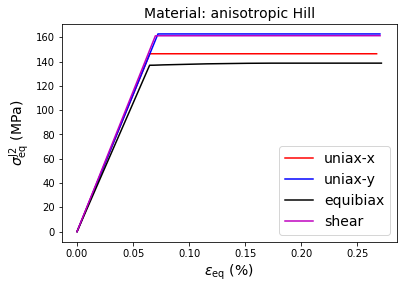

Hill yield stress under uniax-x loading: 150.00000000000006 MPa
Hill yield stress under uniax-y loading: 150.0 MPa
Hill yield stress under equibiax loading: 150.0 MPa
Hill yield stress under shear loading: 150.0 MPa


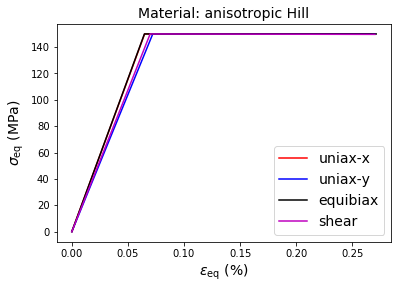

In [3]:
'Calculate and plot stress strain curves of reference material under various load cases'
mat1.calc_properties(verb=False, eps=0.003, sigeps=True)
mat1.plot_stress_strain(Hill=True)  #file='sigHill-eps-ref'

## Setup ML constitutive models

Here, the reference material `mat1` with Hill-type anisotropy is used to produce training and test data for the machine learning algorithm. The yield function is represented as a step function such that Support Vector Classification (SVC) is used. In the FEA all stresses are considered in form of principal stress vectors, such that a coordinate transformation into the cylindrical coordinate system with equivalent stress and polar angle $\theta$ takes place within the training and evaluation procedure. Furthermore, to make the training process efficient, stress data for training and testing are already produced as purely deviatoric stress components, following the cylidrical stress vector definition given above. 

As one cannot assume the Hill-coefficients as know for the ML material, the standard J2 equivalent stresses for isotropic materials must be used in the analysis. In consequence, the yield stress must depend on the angle $\theta$ in order to discribe the anisotropy on the flow behavior. Thus, the yield function takes the form
\begin{equation}
f = \sigma_{eq} - \sigma_y(\theta),
\end{equation}
in which the dependencies on isotropic J2 equivalent stress $\sigma_{eq}$ and angle $\theta$ are separated.

### Train ML yield function
In the following code segment, training and test data are generated and applied for training of the SVC, and the quality test of the result. For the data and the trained ML yield function are plotted in the cylindrical stress space.

Plot theta vs. Hill eqiv. stress curves for reference material with known anisotropic coefficients


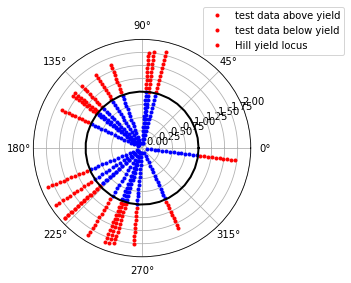


-------------------------

SVM classification fitted
-------------------------

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=4.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Training data points (only polar angle): 36 , Test data points: 20
Training set score: 99.47916666666666 %
Test set score: 99.375 %
r^2 on test data : 0.974457
Plot theta vs. J2 eqiv. stress curves for ML material


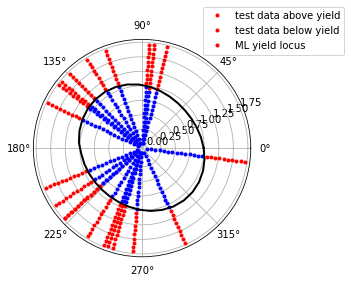

Plot of yield locus and training data in slices of 3D principle stress space


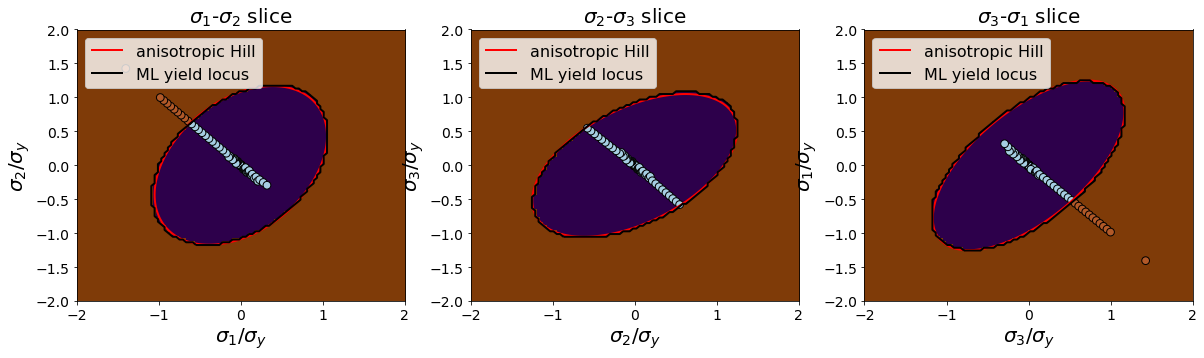

Plot of trained SVM classification with test data in 2D cylindrical stress space


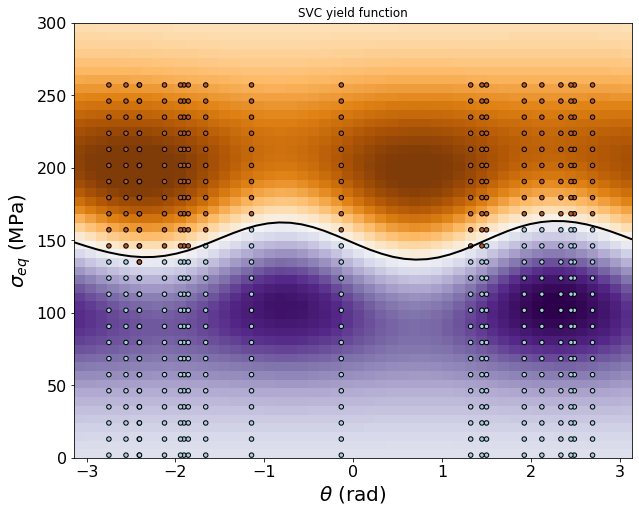

In [4]:
'Create training data in deviatoric stress space for components seq and theta'
def create_data(N, mat, extend=False, rand=False):
    # create stresses along unit circle normal to hydrostatic axis
    if not rand:
        theta = np.linspace(-np.pi, np.pi, N)
    else:
        theta = 2.*(np.random.rand(N)-0.5)*np.pi
    sig = FE.sp_cart(np.array([np.ones(N)*np.sqrt(3/2), theta]).T)
    offs = 0.01
    x = offs*sig
    N = 23
    for i in range(N):
        hh = offs + (1.4-offs)*(i+1)/N
        x = np.append(x, hh*sig, axis=0)
    if extend:
        # add training points in plastic regime to avoid fallback of SVC decision fct. to zero
        x = np.append(x, 2.*sig, axis=0)
        x = np.append(x, 3.*sig, axis=0)
        x = np.append(x, 4.*sig, axis=0) 
        x = np.append(x, 5.*sig, axis=0)
    'result data for ML yield function (only sign is considered)'
    y = np.sign(mat.calc_yf(x*mat.sy, ana=True))
    return x,y 

'Training and testing data for ML yield function, based on reference Material mat1'
ndata = 36
ntest = np.maximum(20, int(ndata/10))
x_train, y_train = create_data(ndata, mat1, extend=True) 
x_test, y_test = create_data(ntest, mat1, rand=True)
x_train *= mat1.sy
x_test *= mat1.sy

print('Plot theta vs. Hill eqiv. stress curves for reference material with known anisotropic coefficients')
ind1 = np.nonzero(y_test<0.)
ind2 = np.nonzero(y_test>=0.)
sc = FE.s_cyl(x_test, mat1)  # convert princ. stresses into cylidrical coordinates
plt.polar(sc[ind2,1],sc[ind2,0]/mat1.sy,'.r')
plt.polar(sc[ind1,1],sc[ind1,0]/mat1.sy,'.b')
plt.polar(np.linspace(0.,2*np.pi,36), np.ones(36), '-k', linewidth=2)
plt.legend(['test data above yield','test data below yield','Hill yield locus'], loc=(0.78,0.93))
#plt.savefig('polar-Hill.pdf', format='pdf', dpi=300)
plt.show()

'initialize and train SVC as ML yield function'
'implement ML flow rule into mat2'
train_sc, test_sc = mat2.setup_yf_SVM(x_train, y_train, x_test=x_test, y_test=y_test, 
                                      C=10, gamma=4., fs=0.3, plot=False)  
y_pred_clf = mat2.calc_yf(x_test,pred=True)
r2_score_svm = r2_score(y_test, y_pred_clf)
print('\n-------------------------\n')
print('SVM classification fitted')
print('-------------------------\n')
print(mat2.svm_yf)
print("Training data points (only polar angle):", ndata,", Test data points:", ntest)
print("Training set score: {} %".format(train_sc))
print("Test set score: {} %".format(test_sc))
print("r^2 on test data : %f" % r2_score_svm)

print('Plot theta vs. J2 eqiv. stress curves for ML material')
ind1 = np.nonzero(y_test<0.)
ind2 = np.nonzero(y_test>=0.)
sc = FE.s_cyl(x_test) # convert princ. stresses into cylindrical coordinates
plt.polar(sc[ind2,1],sc[ind2,0]/mat2.sy,'.r')
plt.polar(sc[ind1,1],sc[ind1,0]/mat2.sy,'.b')
'find norm of princ. stess vector lying on yield surface'
theta = np.linspace(0.,2*np.pi,36)
snorm = FE.sp_cart(np.array([mat2.sy*np.ones(36)*np.sqrt(3/2), theta]).T)
x1 = fsolve(mat2.find_yloc, np.ones(36), args=snorm, xtol=1.e-5)
sig = snorm*np.array([x1,x1,x1]).T
s_yld = mat2.calc_seq(sig)
plt.polar(theta, s_yld/mat2.sy, '-k', linewidth=2)
plt.legend(['test data above yield','test data below yield','ML yield locus'], loc=(0.78,0.93))
#plt.savefig('polar-J2.pdf', format='pdf', dpi=300)
plt.show()

print('Plot of yield locus and training data in slices of 3D principle stress space')
mat2.plot_yield_locus(mat2.calc_yf, label=['ML yield locus'], data=x_train, ref_mat=mat1, trange=3.e-2, 
                      axis1=[0,1,2], axis2=[1,2,0], ref=False) #Nmesh=300,file='yield-fct-slices'

print('Plot of trained SVM classification with test data in 2D cylindrical stress space')
xx, yy = np.meshgrid(np.linspace(-1, 1, 50),np.linspace(-1, 1, 50))
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
feat = np.c_[yy.ravel(),xx.ravel()]
#Z = mat2.svm_yf.predict(feat)
Z = mat2.svm_yf.decision_function(feat)
hl = mat2.plot_data(Z, ax, xx*np.pi, (yy+1.)*mat2.sy, c='black')
sc = FE.s_cyl(x_test)
h1 = ax.scatter(sc[:,1], sc[:,0], s=20, c=y_test, cmap=plt.cm.Paired, edgecolors='k')
ax.set_title('SVC yield function')
ax.set_xlabel(r'$\theta$ (rad)', fontsize=20)
ax.set_ylabel(r'$\sigma_{eq}$ (MPa)', fontsize=20)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
#fig.savefig('SVM-yield-fct.pdf', format='pdf', dpi=300)

### Apply trained ML flow rule in FEA

After the successful training of the ML yield function, it can be applied directly in FEA. Its gradients of can be calculated directly from the coefficients and the support vectors resulting from the training process. The following code segment, demonstrates the application of the ML yield function in the pyLabFEA module. First, a model with two sections is generates, where section 1 is assigned to the reference material ``mat1`` and section 2 is assigned to ``mat2`` with the ML yield function.

=== FEA with reference and ML material ===
Global strain:  [-0.0017  0.004  -0.001   0.      0.     -0.    ]
Element strain (ref):  [-0.0016  0.004  -0.001   0.      0.      0.    ]
Element strain (ML):  [-0.0018  0.004  -0.0009  0.      0.     -0.    ]
Global stress:  [  0.     162.4935   0.       0.       0.      -0.    ]
Element stress (ref):  [  0.     162.5794   0.       0.       0.       0.    ]
Element stress (ML):  [  0.     162.4076   0.       0.       0.      -0.    ]
Global plastic strain:  [-0.00175  0.00308 -0.00134  0.       0.       0.     ]
Plastic strain (ref):  [-0.0016   0.00311 -0.00151  0.       0.       0.     ]
Plastic strain (ML):  [-0.00189  0.00306 -0.00116  0.       0.       0.     ]
----------------------------
Material 1 (left block):   {'yield_fct': 'analytical', 'gradient': 'analytical'}
Material 2 (right block):  {'yield_fct': 'ML_yf-decision-fct', 'gradient': 'gradient to ML_yf'}


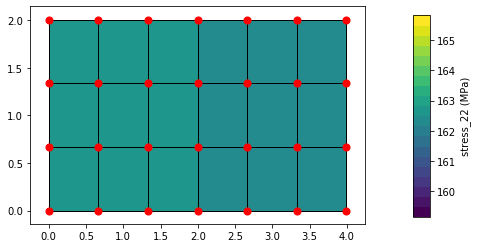

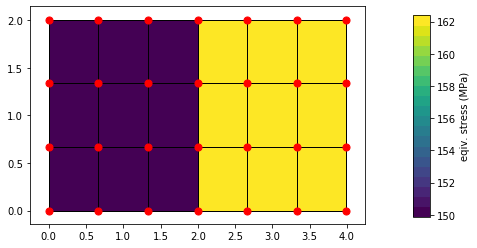

Note: Different definitions of SEQ for Hill and J2.


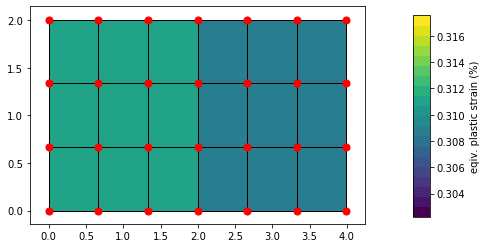

In [5]:
fem=FE.Model(dim=2,planestress=True)
fem.geom([2, 2], LY=2.)  # define sections in absolute lengths

print('==========================================')
print('=== FEA with reference and ML material ===')
print('==========================================')
fem.assign([mat1, mat2])  # create a model with trained ML-flow rule (mat1) and reference material (mat3)
fem.bcleft(0.)
fem.bcbot(0.)
fem.bcright(0., 'force')   # free right edge
fem.bctop(0.004*fem.leny, 'disp')  # apply displacement at top nodes (uniax y-stress)
fem.mesh(NX=6, NY=3)
fem.solve()
fem.calc_global()
print('Global strain: ', np.round(fem.glob['eps'],decimals=4))
print('Element strain (ref): ', np.round(fem.element[0].eps,decimals=4))
print('Element strain (ML): ', np.round(fem.element[10].eps,decimals=4))
print('Global stress: ', np.round(fem.glob['sig'],decimals=4))
print('Element stress (ref): ', np.round(fem.element[0].sig,decimals=4))
print('Element stress (ML): ', np.round(fem.element[10].sig,decimals=4))
print('Global plastic strain: ', np.round(fem.glob['epl'],decimals=5))
print('Plastic strain (ref): ', np.round(fem.element[0].epl,decimals=5))
print('Plastic strain (ML): ', np.round(fem.element[10].epl,decimals=5))
print('----------------------------')
print('Material 1 (left block):  ',mat1.msg)
print('Material 2 (right block): ',mat2.msg)

fem.plot('stress2',mag=1)
fem.plot('seq',mag=1)
print('Note: Different definitions of SEQ for Hill and J2.')
fem.plot('peeq',mag=1)

Note that the element stresses in both materials are very similar (top figure). However, the different definitions of the Hill equivalent stress and the J2 equivalent stress produce a numerical difference in the plot of the equivalent stresses (middle figure). The resulting plastic strains in both sections are quite similar (bottom figure).

The second example applies the same four load cases under which the reference material has been characterized and compares the results.



====== Stress-Strain-Curves ======
J2 yield stress under uniax-x loading: 147.39267596379034 MPa
J2 yield stress under uniax-y loading: 161.51299710165046 MPa
J2 yield stress under equibiax loading: 138.53409225697783 MPa
J2 yield stress under shear loading: 160.25165667614655 MPa


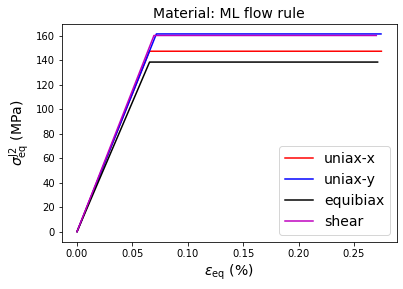

*** load case:  uniax-x
             Rel. error in yield strength :  0.69 %
Rel. error in plastic strain at max. load :  4.5600000000000005 %
*** load case:  uniax-y
             Rel. error in yield strength :  -0.73 %
Rel. error in plastic strain at max. load :  0.49 %
*** load case:  equibiax
             Rel. error in yield strength :  1.17 %
Rel. error in plastic strain at max. load :  -0.02 %
*** load case:  shear
             Rel. error in yield strength :  -0.54 %
Rel. error in plastic strain at max. load :  -0.4 %


In [6]:
print('\n\n====== Stress-Strain-Curves ======')
mat2.calc_properties(verb=False, eps=0.003, min_step=10)
mat2.plot_stress_strain()  # file='sigJ2-eps-ML'
for sel in mat1.prop:
    print('*** load case: ',mat1.prop[sel]['name'])
    print('             Rel. error in yield strength : ', 
          100*np.round(mat2.propJ2[sel]['ys']/mat1.propJ2[sel]['ys']-1.,decimals=4),'%')
    mpl_ref = np.amax(mat1.propJ2[sel]['peeq'])
    mpl_ml1 = np.amax(mat2.propJ2[sel]['peeq'])
    print('Rel. error in plastic strain at max. load : ',
         100*np.round(mpl_ref/mpl_ml1-1.,decimals=4),'%')

## Train ML yield function with results of 4 load cases

In the following, the training data is created only from the four load cases of the reference material. For all load cases $\sigma_3=0$, yet due to the data-oriented formulation of the yield function on the deviatoric plane, a full yield function can be achieved. A new material ``mat3`` is created on which the ML training is performed.

Plot theta vs. J2 eqiv. stress curves for ML material


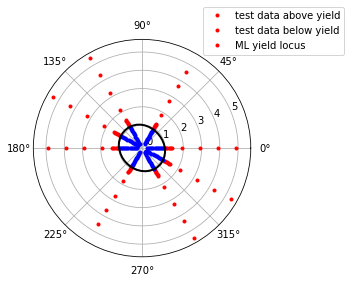


-------------------------

SVM classification fitted
-------------------------

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=4.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Training data points (only polar angle): 36 , Test data points: 20
Training set score: 99.28571428571429 %
Test set score: 99.16666666666667 %
r^2 on test data : 0.965942
Plot of yield locus and training data in slices of 3D principle stress space


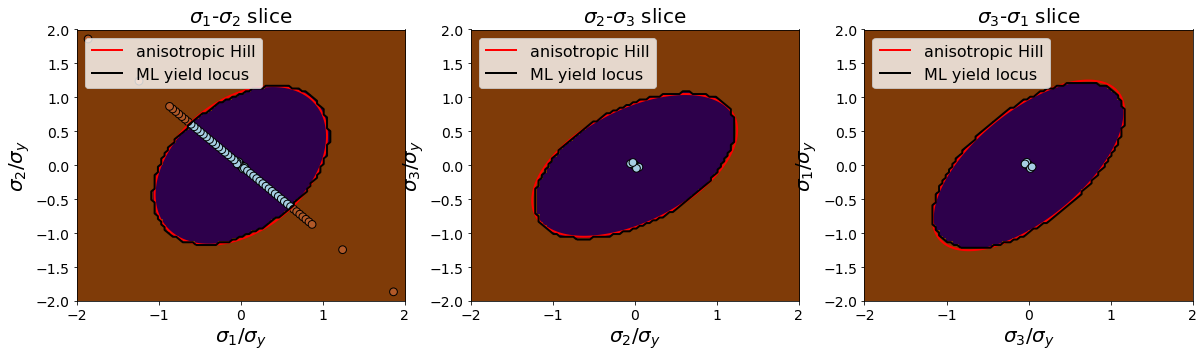

In [7]:
'get principle yield stresses of 4 load cases from reference material'
sig=np.zeros((4,3))
i=0
for sel in mat1.sigeps:
    peeq = FE.eps_eq(mat1.sigeps[sel]['epl'])
    iys = np.nonzero(peeq<1.e-6)  # take stress at last index of elastic regime
    ys = mat1.sigeps[sel]['sig']
    sp_yld = FE.Stress(ys[iys[0][-1]]).p
    sig[i,:] = sp_yld
    i += 1

'mirror data in theta space: tension-compression symmetry'
sc1 = FE.s_cyl(sig)
sc2 = np.zeros((4,3))
sc2[:,0] = sc1[:,0]
sc2[:,1] = sc1[:,1]-np.pi
sc2[:,2] = sc1[:,2]
sc = np.append(sc1,sc2,axis=0)
sig = FE.sp_cart(sc)

'expand stresses into elastic and plastic regimes'
offs = 0.01
x = offs*sig
N = 23
for i in range(N):
    hh = offs + (1.4-offs)*(i+1)/N
    x = np.append(x, hh*sig, axis=0)
# add training points in plastic regime to avoid fallback of SVC decision fct. to zero
x = np.append(x, 2.*sig, axis=0)
x = np.append(x, 3.*sig, axis=0)
x = np.append(x, 4.*sig, axis=0) 
x = np.append(x, 5.*sig, axis=0)

'result data for training of ML yield function'
y = mat2.calc_yf(x, pred=True)

print('Plot theta vs. J2 eqiv. stress curves for ML material')
ind1 = np.nonzero(y<0.)
ind2 = np.nonzero(y>=0.)
sc = FE.s_cyl(x) # convert princ. stresses into cylindrical coordinates
plt.polar(sc[ind2,1],sc[ind2,0]/mat2.sy,'.r')
plt.polar(sc[ind1,1],sc[ind1,0]/mat2.sy,'.b')
'find norm of princ. stess vector lying on yield surface'
theta = np.linspace(0.,2*np.pi,36)
snorm = FE.sp_cart(np.array([mat2.sy*np.ones(36)*np.sqrt(3/2), theta]).T)
x1 = fsolve(mat2.find_yloc, np.ones(36), args=snorm, xtol=1.e-5)
hs = snorm*np.array([x1,x1,x1]).T
s_yld = mat2.calc_seq(hs)
plt.polar(theta, s_yld/mat2.sy, '-k', linewidth=2)
plt.legend(['test data above yield','test data below yield','ML yield locus'], loc=(0.78,0.93))
#plt.savefig('polar-J2.pdf', format='pdf', dpi=300)
plt.show()

'define material for training with new data'
mat3 = Material(name='ML-triax')
mat3.elasticity(E=E, nu=nu)
mat3.plasticity(sy=mat1.sy, hill=[1., 1., 1.], drucker=0., khard=0.)

'initialize and train SVC as yield function'
train_sc, test_sc = mat3.setup_yf_SVM(x, y, x_test=x_test, y_test=y_test, 
                                      C=10, gamma=4., fs=0.3, plot=False)  
y_pred_clf = mat3.calc_yf(x_test,pred=True)
r2_score_svm = r2_score(y_test, y_pred_clf)
print('\n-------------------------\n')
print('SVM classification fitted')
print('-------------------------\n')
print(mat3.svm_yf)
print("Training data points (only polar angle):", ndata,", Test data points:", ntest)
print("Training set score: {} %".format(train_sc))
print("Test set score: {} %".format(test_sc))
print("r^2 on test data : %f" % r2_score_svm)

print('Plot of yield locus and training data in slices of 3D principle stress space')
mat3.plot_yield_locus(mat3.calc_yf, label=['ML yield locus'], ref_mat=mat1, data=x, trange=3.e-2, 
                      axis1=[0,1,2], axis2=[1,2,0], ref=False) #Nmesh=300,file='yield-fct-slices'


## Comparison of different training methods

The following code segment shows the same set of FE simulations as in the case of the yield function fitted to regular training data

=== FEA with reference and ML material ===
Global strain:  [-0.0017  0.004  -0.001   0.      0.     -0.    ]
Element strain (ref):  [-0.0016  0.004  -0.001   0.      0.      0.    ]
Element strain (ML):  [-0.0018  0.004  -0.0009  0.      0.     -0.    ]
Global stress:  [  0.     160.7215   0.       0.       0.      -0.    ]
Element stress (ref):  [  0.     162.5471   0.       0.       0.      -0.    ]
Element stress (ML):  [  0.     158.8959   0.       0.       0.      -0.    ]
Global plastic strain:  [-0.00176  0.00309 -0.00134  0.       0.       0.     ]
Plastic strain (ref):  [-0.0016   0.00311 -0.00151  0.       0.       0.     ]
Plastic strain (ML):  [-0.00191  0.00307 -0.00116  0.       0.       0.     ]
----------------------------
Material 1 (left section):   {'yield_fct': 'analytical', 'gradient': 'analytical'}
Material 3 (right section):  {'yield_fct': 'ML_yf-decision-fct', 'gradient': 'gradient to ML_yf'}


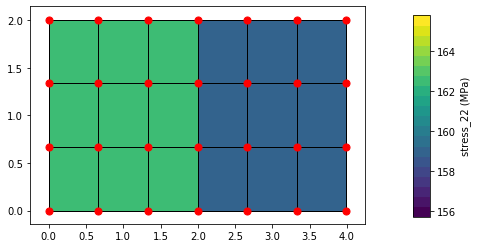

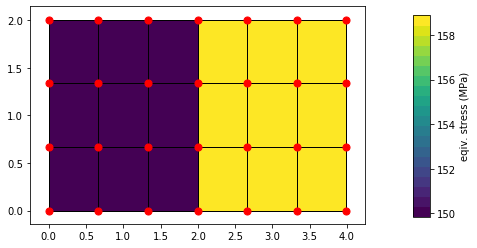

Note: Different definitions of SEQ for Hill and J2.


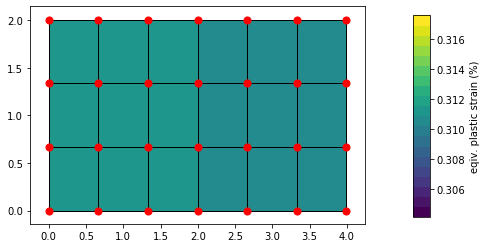



====== Stress-Strain-Curves ======
J2 yield stress under uniax-x loading: 147.4689467007472 MPa
J2 yield stress under uniax-y loading: 157.45741062596537 MPa
J2 yield stress under equibiax loading: 138.0877251702932 MPa
J2 yield stress under shear loading: 156.75589004452848 MPa


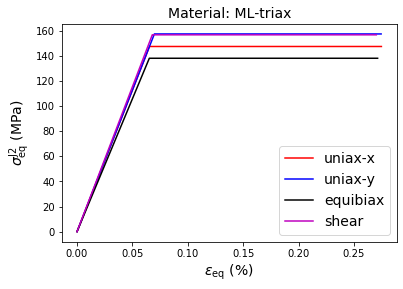

*** load case:  uniax-x
             Rel. error in yield strength :  0.74 %
Rel. error in plastic strain at max. load :  4.58 %
*** load case:  uniax-y
             Rel. error in yield strength :  -3.2199999999999998 %
Rel. error in plastic strain at max. load :  -0.4 %
*** load case:  equibiax
             Rel. error in yield strength :  0.8500000000000001 %
Rel. error in plastic strain at max. load :  -0.12 %
*** load case:  shear
             Rel. error in yield strength :  -2.71 %
Rel. error in plastic strain at max. load :  -1.1400000000000001 %


In [8]:
fem=FE.Model(dim=2,planestress=True)
fem.geom([2, 2], LY=2.)  # define sections in absolute lengths

print('==========================================')
print('=== FEA with reference and ML material ===')
print('==========================================')
fem.assign([mat1, mat3])  # create a model with trained ML-flow rule (mat1) and reference material (mat3)
fem.bcleft(0.)
fem.bcbot(0.)
fem.bcright(0., 'force')   # free right edge
fem.bctop(0.004*fem.leny, 'disp')  # apply displacement at top nodes (uniax y-stress)
fem.mesh(NX=6, NY=3)
fem.solve()
fem.calc_global()
print('Global strain: ', np.round(fem.glob['eps'],decimals=4))
print('Element strain (ref): ', np.round(fem.element[0].eps,decimals=4))
print('Element strain (ML): ', np.round(fem.element[10].eps,decimals=4))
print('Global stress: ', np.round(fem.glob['sig'],decimals=4))
print('Element stress (ref): ', np.round(fem.element[0].sig,decimals=4))
print('Element stress (ML): ', np.round(fem.element[10].sig,decimals=4))
print('Global plastic strain: ', np.round(fem.glob['epl'],decimals=5))
print('Plastic strain (ref): ', np.round(fem.element[0].epl,decimals=5))
print('Plastic strain (ML): ', np.round(fem.element[10].epl,decimals=5))
print('----------------------------')
print('Material 1 (left section):  ',mat1.msg)
print('Material 3 (right section): ',mat3.msg)

fem.plot('stress2',mag=1)
fem.plot('seq',mag=1)
print('Note: Different definitions of SEQ for Hill and J2.')
fem.plot('peeq',mag=1)

print('\n\n====== Stress-Strain-Curves ======')
mat3.calc_properties(verb=False, eps=0.003, min_step=10)
mat3.plot_stress_strain()  # file='sigJ2-eps-ML'
for sel in mat1.prop:
    print('*** load case: ',mat1.prop[sel]['name'])
    print('             Rel. error in yield strength : ', 
          100*np.round(mat3.propJ2[sel]['ys']/mat1.propJ2[sel]['ys']-1.,decimals=4),'%')
    mpl_ref = np.amax(mat1.propJ2[sel]['peeq'])
    mpl_ml1 = np.amax(mat3.propJ2[sel]['peeq'])
    print('Rel. error in plastic strain at max. load : ',
         100*np.round(mpl_ref/mpl_ml1-1.,decimals=4),'%')